In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from scipy.ndimage import label
from skimage.filters import threshold_otsu
import random
import json
import os
import utils

# Venv namesten


In [2]:
# Accuracy - output images vs mask image - false positive % and false negative %%!
# Get average tumor size, also max and min tumor
# Tumor heatmap - if not on heatmap, then probably not tumor
# 
# 1. Check symmetry differences
# 2. Cancel out whites not on the heatmap
# 3. If a part has the largest connected white cluster , probably the tumor
# 4. Check if circle-like (Optional)

# Get training and other data
raw = os.listdir("./data/dataset/images")

random.shuffle(raw)

raw_train = raw[0:2800]
raw_test = raw[2801:3063]

# Choose train data and remember it
writeStr = ""
for item in raw_train:
    writeStr+=item.split("/")[-1].replace(".png","")+","
print(writeStr)

f = open("./data/train.csv","w")
f.write(writeStr)
f.close()

# Choose test data and remember it
writeStr = ""
for item in raw_test:
    writeStr+=item.split("/")[-1].replace(".png","")+","
print(writeStr)

f = open("./data/test.csv","w")
f.write(writeStr)
f.close()


1473,1671,248,116,1999,1112,781,1079,207,2282,1472,2452,1741,858,1601,1325,554,2087,2935,2752,1254,1430,459,596,1132,1847,2,2774,1797,321,239,819,2584,3007,2496,2420,667,1744,92,1540,2787,2443,2519,251,2237,2689,1393,2448,1398,551,2773,2794,705,755,2108,414,2422,2646,743,721,926,949,2205,2601,2313,2154,2783,1381,3036,313,1411,1929,2996,1746,2467,685,1479,1521,2401,1412,2163,2560,1500,1832,2771,202,1566,740,454,290,966,99,2878,1596,2546,1977,2236,75,182,289,2570,1360,2740,466,1163,2322,2561,2386,1080,1615,338,2334,2256,2397,830,2541,1876,327,1251,814,103,1374,701,1368,833,661,802,1326,2127,268,924,2056,951,1308,2188,1974,2799,2094,2329,1621,1750,1518,2113,911,973,2624,709,1710,2370,2524,2389,900,1285,392,2194,425,1258,2072,1143,2364,128,2299,2843,2714,2092,1921,2062,209,547,896,616,811,1320,2317,609,379,1198,2877,2407,1890,2918,947,1040,72,2675,2962,589,1474,1121,2474,1801,2353,1172,2451,2769,1101,2408,2085,3062,2807,889,2658,1431,2859,2456,314,2827,2617,693,1766,2747,2849,2910,1663,288

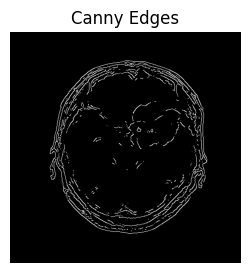

In [3]:
img_path = './data/dataset/images/2.png'
img = cv2.imread(img_path)  # Convert to grayscale

blurred_img = cv2.GaussianBlur(np.array(img), (5, 5), 0)  # Apply Gaussian blur

# Convert to NumPy array
img_array = np.array(blurred_img).astype(np.uint8)

edges = cv2.Canny(img_array, threshold1=100, threshold2=100)

# Display the result
plt.figure(figsize=(3, 3))
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.title("Canny Edges")
plt.show()


In [4]:
#acccuracy
def accuracy(prediction, maskfr):
    prediction = (prediction > 127).astype(np.uint8)
    maskfr = (maskfr > 127).astype(np.uint8)

    sM = np.sum(maskfr == 1)

    # Compute values
    TP = np.sum((prediction == 1) & (maskfr == 1)) 
    TN = np.sum((prediction == 0) & (maskfr == 0))
    FP = np.sum((prediction == 1) & (maskfr == 0))
    FN = np.sum((prediction == 0) & (maskfr == 1))

    total = prediction.size
    return FP / sM, FN / total, TP / sM, TN / total


In [5]:
#image from BGR to GRAYSCALE
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#nestpo
#get the threshold
thresh = threshold_otsu(gray_image)
#create a copy of the gray image
bw_img1 = np.copy(gray_image)
#apply the binarization
bw_img1[bw_img1 < thresh] = 0
bw_img1[bw_img1 >= thresh] = 255

#plt.imshow(bw_img1)

cv2.imwrite("otsu.png", bw_img1)

True

In [6]:
# equalised histogram
img_eq = cv2.equalizeHist(img)
thresh, bw_img = cv2.threshold(img_eq, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print("Otsu threshold after histogram equalization:", thresh)

#plt.imshow(bw_img, cmap='gray')
#plt.axis('off')
#plt.show()


Otsu threshold after histogram equalization: 108.0


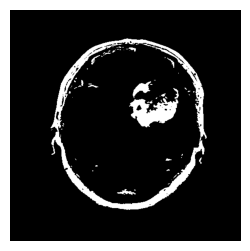

In [7]:
thresh, _ = cv2.threshold(img_eq, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
adjusted_thresh = thresh + 120 # add some offset
_, bw_img = cv2.threshold(img_eq, adjusted_thresh, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(3, 3))
plt.imshow(bw_img, cmap='gray')
plt.axis('off')
plt.show()

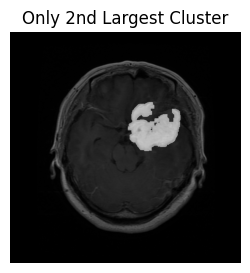

In [8]:
bw_img2 = cv2.dilate(bw_img, np.ones((6, 6), np.uint8), iterations=1)
num_labels, labels = cv2.connectedComponents(bw_img2)

clusters = []
label_sizes = []
for label in range(1, num_labels):
    ys, xs = np.where(labels == label)
    cluster = list(zip(xs, ys))
    clusters.append(cluster)
    label_sizes.append(len(cluster))

sorted_indices = np.argsort(label_sizes)  # ascending
second_largest_label = 1 + sorted_indices[-2]  
labels_only_second = np.where(labels == second_largest_label, 255, 0).astype(np.uint8)
binary_only_second_largest = labels_only_second

binary_only_second_largest = cv2.dilate(binary_only_second_largest, np.ones((3, 3), np.uint8), iterations=1)
plt.figure(figsize=(3, 3))
plt.imshow(binary_only_second_largest, cmap='gray')
plt.imshow(img,cmap='gray',alpha=0.5)
plt.axis('off')
plt.title("Only 2nd Largest Cluster")
plt.show()


False positive: 2.64%
False negative: 1.86%
True positive: 0.00%
True negative: 95.50%
2662


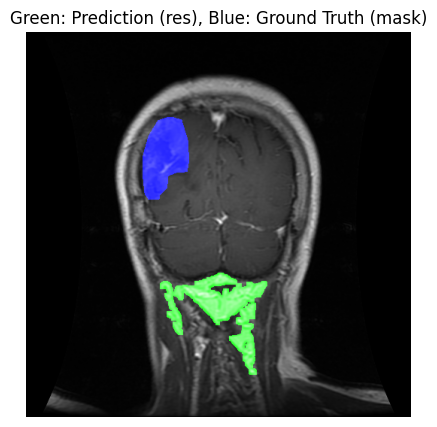

In [9]:
ind = random.randint(0,3000)
img_path = f"./data/dataset/images/{ind}.png"

# Get prediction (res)
res = utils.DOSPredict(img_path)

# Read original grayscale image and mask
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(img_path.replace("images", "masks"), cv2.IMREAD_GRAYSCALE)

# Normalize all images to [0,1] range
img_norm = img / 255.0
res_norm = res / 255.0
mask_norm = mask / 255.0

# Stack into RGB: img as base (gray), res in green, mask in blue
# Base RGB image from grayscale
rgb_img = np.stack([img_norm]*3, axis=-1)

# Overlay green (res) and blue (mask)
rgb_img[..., 1] = np.clip(rgb_img[..., 1] + res_norm, 0, 1)  # Green channel
rgb_img[..., 2] = np.clip(rgb_img[..., 2] + mask_norm, 0, 1)  # Blue channel

# Accuracy
fp, fn, tp, tn = utils.accuracy(res, mask)
print(f"False positive: {fp*100:.2f}%")
print(f"False negative: {fn*100:.2f}%")
print(f"True positive: {tp*100:.2f}%")
print(f"True negative: {tn*100:.2f}%")
print(ind)
# Plot
plt.figure(figsize=(5, 5))
plt.imshow(rgb_img)
plt.axis('off')
plt.title("Green: Prediction (res), Blue: Ground Truth (mask)")
plt.show()


In [10]:

image_dir = './data/dataset/images'
mask_dir = './data/dataset/masks'
image_files = sorted(os.listdir(image_dir))[:3000]

stats = {
    
}

for i, filename in enumerate(image_files):
    img_path = os.path.join(image_dir, filename)
    mask_path = os.path.join(mask_dir, filename)

    prediction = utils.DOSPredict(img_path)
    if prediction is None:
        continue
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    fp, fn, tp, tn = utils.accuracy(prediction, mask)
    
    stats[str(i)] = [fp,fn,tp,tn]

f = open("./data/stats.json","w")
f.write(json.dumps(stats))  
f.close()

        


Error: index -2 is out of bounds for axis 0 with size 1 - ./data/dataset/images/114.png
Error: index -2 is out of bounds for axis 0 with size 1 - ./data/dataset/images/119.png
Error: index -2 is out of bounds for axis 0 with size 1 - ./data/dataset/images/133.png
Error: index -2 is out of bounds for axis 0 with size 1 - ./data/dataset/images/134.png
Error: index -2 is out of bounds for axis 0 with size 1 - ./data/dataset/images/15.png
Error: index -2 is out of bounds for axis 0 with size 1 - ./data/dataset/images/157.png
Error: index -2 is out of bounds for axis 0 with size 1 - ./data/dataset/images/158.png
Error: index -2 is out of bounds for axis 0 with size 1 - ./data/dataset/images/163.png
Error: index -2 is out of bounds for axis 0 with size 1 - ./data/dataset/images/174.png
Error: index -2 is out of bounds for axis 0 with size 1 - ./data/dataset/images/177.png
Error: index -2 is out of bounds for axis 0 with size 1 - ./data/dataset/images/181.png
Error: index -2 is out of bounds 

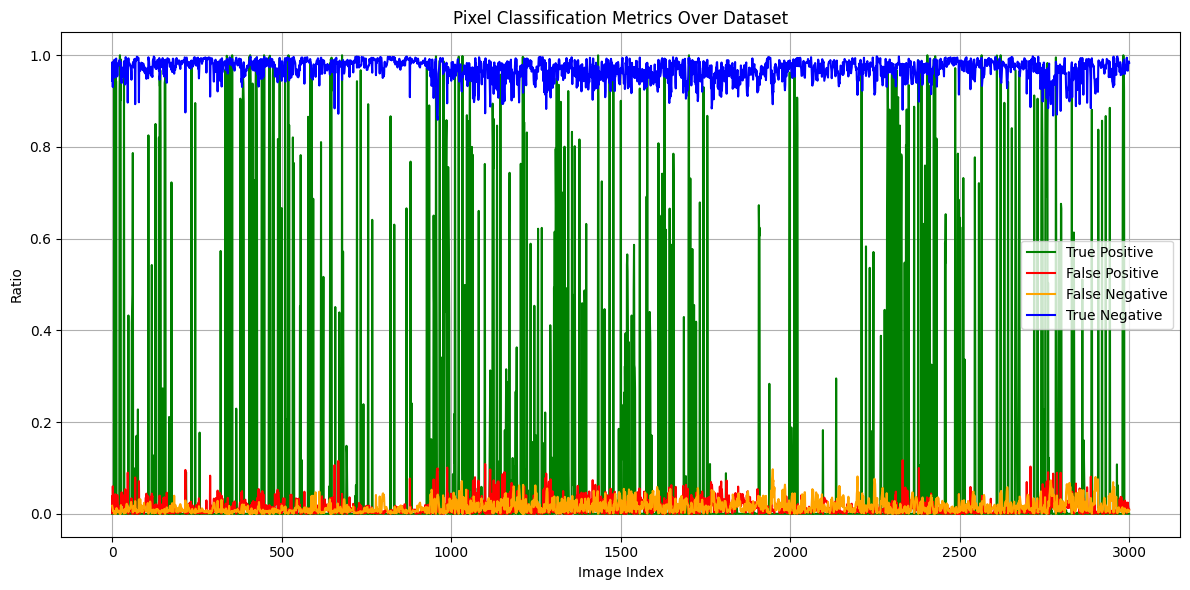

In [ ]:
with open("./data/stats.json", "r") as f:
    stats = json.load(f)

# Convert to lists
indices = list(map(int, stats.keys()))
fp = [stats[str(i)][0] for i in indices]
fn = [stats[str(i)][1] for i in indices]
tp = [stats[str(i)][2] for i in indices]
tn = [stats[str(i)][3] for i in indices]

print(sum(tp)/len(tp))
print(sum(fp)/len(fp))


# Plot all metrics
plt.figure(figsize=(12, 6))
plt.plot(indices, tp, label="True Positive", color="green")
plt.plot(indices, fp, label="False Positive", color="red")
plt.plot(indices, fn, label="False Negative", color="orange")
plt.plot(indices, tn, label="True Negative", color="blue")
plt.xlabel("Image Index")
plt.ylabel("Ratio")
plt.title("Pixel Classification Metrics Over Dataset")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
